In [ ]:
# Date    :   2024-12-01
# Author  :   Dongwoo Yoon
# Contact :   dbsehddn0901@gmail.com


# 라이브러리 import

In [1]:
# 파일 및 데이터 조작 관련 라이브러리
import os
from glob import glob
from collections import Counter

# 데이터 분석 및 데이터프레임 조작
import pandas as pd
from sklearn.model_selection import train_test_split

# 딥러닝 및 PyTorch 관련 라이브러리
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import StepLR

# 데이터 시각화 및 이미지 처리
import matplotlib.pyplot as plt
from PIL import Image

# 기타 유틸리티
import random
import numpy as np
from tqdm import tqdm

# Colab 전용 파일 업로드 도구
from google.colab import files


# 데이터셋 로드

In [ ]:
!pip install kaggle

In [ ]:
# upload kaggle.json
files.upload()

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# download datasets
!kaggle datasets download -d jangedoo/utkface-new

In [ ]:
!unzip utkface-new.zip

In [7]:
folder_name = 'UTKFace'

file_mapping = {
    "UTKFace/61_1_20170109142408075.jpg.chip.jpg": "UTKFace/61_1_1_20170109142408075.jpg.chip.jpg",
    "UTKFace/39_1_20170116174525125.jpg.chip.jpg": "UTKFace/39_0_1_20170116174525125.jpg.chip.jpg",
    "UTKFace/61_1_20170109150557335.jpg.chip.jpg": "UTKFace/61_1_3_20170109150557335.jpg.chip.jpg"
}

def parse_dataset(dataset_path, ext='jpg'):
    def parse_info_from_file(path):
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, _, _ = filename.split('_')

            '''
              손실 함수로 nn.CrossEntropyLoss() 사용

              nn.CrossEntropyLoss는 모델 출력(logits)과 정수형 레이블을 입력

              정수형 레이블은 0부터 시작하는 정수값.

              따라서 age 레이블을 다음과 같이 변경

              1         ->  0
              2         ->  1
              3         ->  2
                    .
                    .
                    .
              79        ->  78
              80 ~ 89   ->  79
              90 ~ 116  ->  80
            '''
            if int(age) // 10 == 8:
                age = 79
            elif int(age) // 10 >= 9:
                age = 80
            else:
                age = int(age) - 1

            return age, int(gender)
        except Exception as ex:
            return None, None

    files = glob(os.path.join(dataset_path, "*.%s" % ext))

    records = []
    for file in files:

        if file in file_mapping:
            file = file_mapping[file]

        info = parse_info_from_file(file)
        if info[0] is not None:
            records.append(info)
        else:
          print(file)

    df = pd.DataFrame(records)

    df['file'] = files[:len(records)]
    df.columns = ['age', 'gender', 'file']
    df = df.dropna()

    return df

df = parse_dataset(folder_name)

print(df.head())

   age  gender                                           file
0   11       1  UTKFace/12_1_0_20170109204241570.jpg.chip.jpg
1   21       0  UTKFace/22_0_1_20170113150439151.jpg.chip.jpg
2    8       0   UTKFace/9_0_2_20170110224555634.jpg.chip.jpg
3   79       1  UTKFace/84_1_0_20170110140658706.jpg.chip.jpg
4   49       0  UTKFace/50_0_0_20170104021859988.jpg.chip.jpg


In [8]:
number_of_age_classes = len(df['age'].unique())
print(number_of_age_classes)

81


# GPU 환경

In [9]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

!nvidia-smi

True
1
Wed Dec  4 07:15:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+------------------

# 랜덤시드 고정

In [10]:
def seed_everything(seed):
    random.seed(seed)  # Python
    np.random.seed(seed)  # NumPy
    torch.manual_seed(seed)  # PyTorch
    torch.cuda.manual_seed(seed)  # PyTorch cuda
    torch.backends.cudnn.deterministic = True  # CuDNN
    torch.backends.cudnn.benchmark = False  # CuDNN benchmark

In [11]:
seed_everything(seed=32)

# Train / Valid / Test 데이터셋 분리

- UTKFace 데이터는 train, valid, test 데이터셋 구분이 없어 분리 필요

- Ratio
      train : valid : test = 7 : 2 : 1

In [12]:
# stratify는 **데이터를 분할(split)**할 때, 특정 컬럼이나 배열의 클래스 분포를 유지하도록 도와주는 역할을 합니다.
stratify_array = np.array(list(zip(df['age'], df['gender'])))

# df -> 70% train_df, 30% temp_df
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% temp_df
    random_state=0,
    shuffle=True,
    stratify=stratify_array,
)

temp_stratify_array = np.array(list(zip(temp_df['age'], temp_df['gender'])))

# temp_df -> valid_df, test_df (2:1)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,  # 1/3 test_df
    random_state=0,
    shuffle=True,
    stratify=temp_stratify_array,
)

# print result
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")


Train set size: 16595
Validation set size: 4742
Test set size: 2371


# DataSet, DataLoader 생성


In [13]:
# 사용자 정의 데이터셋 클래스 생성 (CustomDataset)
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        # 데이터셋 초기화
        # dataframe: 이미지 경로와 age, gender가 포함된 데이터프레임
        # transform: 이미지에 적용할 전처리(transform) 함수
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        # 데이터셋의 총 샘플 수 반환
        return len(self.dataframe)

    def __getitem__(self, idx):
        # 주어진 인덱스(idx)에 해당하는 샘플을 반환
        # 이미지 경로를 데이터프레임에서 가져옴
        img_name = self.dataframe.iloc[idx, 2]
        # 이미지 파일을 열고 RGB 모드로 변환
        img = Image.open(img_name).convert('RGB')
        # age와 gender 정보를 정수형으로 가져옴
        age = int(self.dataframe.iloc[idx, 0])
        gender = int(self.dataframe.iloc[idx, 1])

        # transform이 지정되어 있다면 이미지에 전처리를 적용
        if self.transform:
            img = self.transform(img)

        # 이미지와 age, gender를 반환
        return img, age, gender


In [14]:
# 이미지 전처리를 위한 변환 작업 정의
transform = transforms.Compose([
    transforms.ToTensor(),  # 이미지를 Tensor로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

batch_size = 128

# 데이터 로더 설정
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

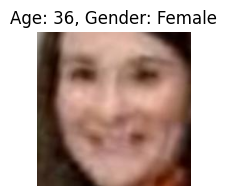

In [15]:
# Train dataset에서 첫 번째 샘플 가져오기
img, age, gender = train_dataset[0]

# 텐서를 이미지로 변환
img = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]
img = (img * 255)

# 이미지 시각화
plt.figure(figsize=(2, 2))
plt.imshow(img)
plt.title(f"Age: {age}, Gender: {'Male' if gender == 0 else 'Female'}")
plt.axis('off')
plt.show()


# 전이 학습 (Transfer Learning)

## 1 . 모델


In [16]:
# 모델 클래스 정의
class AgeGenderModel(nn.Module):
    def __init__(self, base_model, num_age_classes):
        super(AgeGenderModel, self).__init__()

        # 사전 학습된 모델 로드
        self.base_model = base_model

        # 기존 fc를 새로운 사용자 정의 fc로 대체
        num_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # 성별 출력 계층
        self.gender_logits = nn.Linear(128, 2)  # 성별 분류 (2개 클래스)

        # 나이 출력 계층
        self.age_logits = nn.Linear(128, num_age_classes)  # 나이 분류 (81개 클래스)

    def forward(self, x):
        # 순전파 정의
        features = self.base_model(x)
        gender_logits = self.gender_logits(features)  # 성별 출력 logits
        age_logits = self.age_logits(features)  # 나이 출력 logits
        return gender_logits, age_logits


In [ ]:
# 사전 학습된 ResNet18 모델 불러오기
base_model = models.resnet18(pretrained=True)  # ImageNet 데이터로 학습된 ResNet18 모델 로드

# Pretrained 모델의 모든 가중치 고정
for param in base_model.parameters():
    param.requires_grad = False  # ResNet18의 가중치를 고정하여 학습되지 않도록 설정 (특징 추출기로 사용)

# AgeGenderModel 정의
model = AgeGenderModel(base_model, number_of_age_classes)  # 사용자 정의 AgeGenderModel 생성

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 사용 가능 여부에 따라 디바이스 설정 (GPU 또는 CPU)

# 모델을 설정된 디바이스로 이동
model = model.to(device)  # 모델을 GPU 또는 CPU로 이동


## 2 . 손실 함수

In [18]:
# 교차 엔트로피 손실 함수 초기화
criterion_gender = nn.CrossEntropyLoss()  # 성별 출력에 대한 손실
criterion_age = nn.CrossEntropyLoss()     # 나이 출력에 대한 손실

# 총 손실 계산 함수
def calculate_total_loss(gender_preds, age_preds, gender_labels, age_labels, alpha=1.0, beta=1.0):
    loss_gender = criterion_gender(gender_preds, gender_labels)
    loss_age = criterion_age(age_preds, age_labels)
    total_loss = alpha * loss_gender + beta * loss_age
    return total_loss


## 3 . 옵티마이저

In [19]:
# 최적화 알고리즘으로 Adam 사용
# filter(lambda p: p.requires_grad, model.parameters())는 requires_grad=True로 설정된 파라미터만 옵티마이저에 전달
# - 사전 학습된 모델의 고정된 파라미터(requires_grad=False)를 제외하여 불필요한 계산 낭비 방지
# - lr: 학습률(learning rate), weight_decay: L2 정규화 항
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # 학습 가능한 파라미터만 전달
    lr=1e-3,  # 학습률 설정
    weight_decay=1e-5  # 가중치 감소(L2 정규화)로 과적합 방지
)

# StepLR 스케줄러 정의 (매 10 에폭마다 학습률을 0.1배씩 감소)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

## 4 . 학습

In [ ]:
# 학습 파라미터 설정
num_epochs = 50
best_val_acc = 0.0
patience = 5
no_improve = 0

# 훈련 및 검증 손실을 추적하기 위한 리스트
train_losses = []
valid_losses = []

# 훈련 및 검증 나이 Top-3 정확도 추적하기 위한 리스트
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct_gender = 0
    train_correct_age_top3 = 0
    train_total = 0

    for inputs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()

        # 모델의 출력
        gender_logits, age_logits = model(inputs)

        # 손실 계산
        total_loss = calculate_total_loss(gender_logits, age_logits, genders, ages, beta=2.0)

        # 역전파
        total_loss.backward()
        optimizer.step()

        train_running_loss += total_loss.item()

        # 성별 정확도 계산
        _, predicted_gender = torch.max(gender_logits, 1)
        train_correct_gender += (predicted_gender == genders).sum().item()

        # 나이 예측에 대한 Top-3 정확도 계산
        _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
        train_correct_age_top3 += (predicted_age_top3 == ages.unsqueeze(1)).sum().item()  # predicted_age_top3는 [batch_size, 3] 형태이고, ages는 [batch_size]이므로 unsqueeze(1)

        train_total += ages.size(0)

    # 평균 손실 및 정확도 계산
    train_avg_loss = train_running_loss / len(train_loader)
    train_acc_gender = train_correct_gender / train_total
    train_acc_age_top3 = train_correct_age_top3 / train_total

    # 검증 단계
    model.eval()
    val_running_loss = 0.0
    val_correct_gender = 0
    val_correct_age_top3 = 0
    val_total = 0

    with torch.no_grad():
        for inputs, ages, genders in valid_loader:
            inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

            # 모델의 출력
            gender_logits, age_logits = model(inputs)

            # 총 손실 계산
            total_loss = calculate_total_loss(gender_logits, age_logits, genders, ages, beta=2.0)

            val_running_loss += total_loss.item()

            # 성별 정확도 계산
            _, predicted_gender = torch.max(gender_logits, 1)
            val_correct_gender += (predicted_gender == genders).sum().item()

            # 나이 예측에 대한 Top-3 정확도 계산
            _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
            val_correct_age_top3 += (predicted_age_top3 == ages.unsqueeze(1)).sum().item()

            val_total += ages.size(0)

    # 평균 검증 손실 및 정확도 계산
    val_avg_loss = val_running_loss / len(valid_loader)
    val_acc_gender = val_correct_gender / val_total
    val_acc_age_top3 = val_correct_age_top3 / val_total

    # 손실 기록
    train_losses.append(train_avg_loss)
    valid_losses.append(val_avg_loss)

    # 나이 Top-3 정확도 기록
    train_accs.append(train_acc_age_top3)
    valid_accs.append(val_acc_age_top3)

    # 학습 및 검증 결과 출력
    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {train_avg_loss:.4f}, Train Gender Acc: {train_acc_gender:.4f}, Train Age Top-3 Acc: {train_acc_age_top3:.4f}")
    print(f"  Val Loss: {val_avg_loss:.4f}, Val Gender Acc: {val_acc_gender:.4f}, Val Age Top-3 Acc: {val_acc_age_top3:.4f}")

    # 조기 종료를 위한 정확도 비교 (Age Top-3 기준)
    if val_acc_age_top3 > best_val_acc:
        best_val_acc = val_acc_age_top3
        no_improve = 0
        # 모델 저장
        torch.save(model.state_dict(), f"best_model.pth")
        print(f"Model saved at epoch {epoch+1}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

    # 스케줄러 step 호출 (매 에폭 끝에서 호출)
    scheduler.step()


Epoch 1/50: 100%|██████████| 130/130 [00:18<00:00,  7.20it/s]


Epoch [1/50]:
  Train Loss: 8.5917, Train Gender Acc: 0.6481, Train Age Top-3 Acc: 0.1929
  Val Loss: 7.9552, Val Gender Acc: 0.7611, Val Age Top-3 Acc: 0.2638
Model saved at epoch 1


Epoch 2/50: 100%|██████████| 130/130 [00:16<00:00,  7.84it/s]


Epoch [2/50]:
  Train Loss: 7.8787, Train Gender Acc: 0.7472, Train Age Top-3 Acc: 0.2459
  Val Loss: 7.5141, Val Gender Acc: 0.7750, Val Age Top-3 Acc: 0.2819
Model saved at epoch 2


Epoch 3/50: 100%|██████████| 130/130 [00:16<00:00,  7.83it/s]


Epoch [3/50]:
  Train Loss: 7.6680, Train Gender Acc: 0.7622, Train Age Top-3 Acc: 0.2622
  Val Loss: 7.3754, Val Gender Acc: 0.7714, Val Age Top-3 Acc: 0.2940
Model saved at epoch 3


Epoch 4/50: 100%|██████████| 130/130 [00:16<00:00,  7.78it/s]


Epoch [4/50]:
  Train Loss: 7.4929, Train Gender Acc: 0.7682, Train Age Top-3 Acc: 0.2748
  Val Loss: 7.2831, Val Gender Acc: 0.7889, Val Age Top-3 Acc: 0.3007
Model saved at epoch 4


Epoch 5/50: 100%|██████████| 130/130 [00:16<00:00,  7.67it/s]


Epoch [5/50]:
  Train Loss: 7.4322, Train Gender Acc: 0.7734, Train Age Top-3 Acc: 0.2771
  Val Loss: 7.1683, Val Gender Acc: 0.7921, Val Age Top-3 Acc: 0.3001


Epoch 6/50: 100%|██████████| 130/130 [00:17<00:00,  7.58it/s]


Epoch [6/50]:
  Train Loss: 7.3540, Train Gender Acc: 0.7754, Train Age Top-3 Acc: 0.2888
  Val Loss: 7.1946, Val Gender Acc: 0.8020, Val Age Top-3 Acc: 0.3102
Model saved at epoch 6


Epoch 7/50: 100%|██████████| 130/130 [00:17<00:00,  7.63it/s]


Epoch [7/50]:
  Train Loss: 7.3275, Train Gender Acc: 0.7778, Train Age Top-3 Acc: 0.2865
  Val Loss: 7.1076, Val Gender Acc: 0.8049, Val Age Top-3 Acc: 0.3089


Epoch 8/50: 100%|██████████| 130/130 [00:16<00:00,  7.68it/s]


Epoch [8/50]:
  Train Loss: 7.2732, Train Gender Acc: 0.7872, Train Age Top-3 Acc: 0.2908
  Val Loss: 7.1021, Val Gender Acc: 0.7997, Val Age Top-3 Acc: 0.3062


Epoch 9/50: 100%|██████████| 130/130 [00:17<00:00,  7.62it/s]


Epoch [9/50]:
  Train Loss: 7.2376, Train Gender Acc: 0.7863, Train Age Top-3 Acc: 0.2935
  Val Loss: 7.0856, Val Gender Acc: 0.8030, Val Age Top-3 Acc: 0.3045


Epoch 10/50: 100%|██████████| 130/130 [00:17<00:00,  7.58it/s]


Epoch [10/50]:
  Train Loss: 7.2130, Train Gender Acc: 0.7837, Train Age Top-3 Acc: 0.2955
  Val Loss: 7.0697, Val Gender Acc: 0.7995, Val Age Top-3 Acc: 0.3193
Model saved at epoch 10


Epoch 11/50: 100%|██████████| 130/130 [00:17<00:00,  7.59it/s]


Epoch [11/50]:
  Train Loss: 7.1005, Train Gender Acc: 0.8007, Train Age Top-3 Acc: 0.3023
  Val Loss: 7.0209, Val Gender Acc: 0.8070, Val Age Top-3 Acc: 0.3199
Model saved at epoch 11


Epoch 12/50: 100%|██████████| 130/130 [00:17<00:00,  7.57it/s]


Epoch [12/50]:
  Train Loss: 7.0727, Train Gender Acc: 0.8020, Train Age Top-3 Acc: 0.3052
  Val Loss: 7.0243, Val Gender Acc: 0.8108, Val Age Top-3 Acc: 0.3178


Epoch 13/50: 100%|██████████| 130/130 [00:17<00:00,  7.61it/s]


Epoch [13/50]:
  Train Loss: 7.0714, Train Gender Acc: 0.8027, Train Age Top-3 Acc: 0.3037
  Val Loss: 7.0002, Val Gender Acc: 0.8100, Val Age Top-3 Acc: 0.3172


Epoch 14/50: 100%|██████████| 130/130 [00:17<00:00,  7.62it/s]


Epoch [14/50]:
  Train Loss: 7.0576, Train Gender Acc: 0.8010, Train Age Top-3 Acc: 0.3088
  Val Loss: 7.0192, Val Gender Acc: 0.8121, Val Age Top-3 Acc: 0.3210
Model saved at epoch 14


Epoch 15/50: 100%|██████████| 130/130 [00:17<00:00,  7.62it/s]


Epoch [15/50]:
  Train Loss: 7.0433, Train Gender Acc: 0.8040, Train Age Top-3 Acc: 0.3095
  Val Loss: 7.0053, Val Gender Acc: 0.8094, Val Age Top-3 Acc: 0.3214
Model saved at epoch 15


Epoch 16/50: 100%|██████████| 130/130 [00:16<00:00,  7.67it/s]


Epoch [16/50]:
  Train Loss: 7.0421, Train Gender Acc: 0.8041, Train Age Top-3 Acc: 0.3085
  Val Loss: 7.0024, Val Gender Acc: 0.8056, Val Age Top-3 Acc: 0.3208


Epoch 17/50: 100%|██████████| 130/130 [00:17<00:00,  7.57it/s]


Epoch [17/50]:
  Train Loss: 7.0345, Train Gender Acc: 0.8063, Train Age Top-3 Acc: 0.3061
  Val Loss: 7.0086, Val Gender Acc: 0.8096, Val Age Top-3 Acc: 0.3241
Model saved at epoch 17


Epoch 18/50: 100%|██████████| 130/130 [00:17<00:00,  7.64it/s]


Epoch [18/50]:
  Train Loss: 7.0333, Train Gender Acc: 0.7989, Train Age Top-3 Acc: 0.3069
  Val Loss: 6.9974, Val Gender Acc: 0.8140, Val Age Top-3 Acc: 0.3250
Model saved at epoch 18


Epoch 19/50: 100%|██████████| 130/130 [00:17<00:00,  7.62it/s]


Epoch [19/50]:
  Train Loss: 7.0346, Train Gender Acc: 0.8049, Train Age Top-3 Acc: 0.3067
  Val Loss: 6.9892, Val Gender Acc: 0.8142, Val Age Top-3 Acc: 0.3224


Epoch 20/50: 100%|██████████| 130/130 [00:17<00:00,  7.62it/s]


Epoch [20/50]:
  Train Loss: 7.0204, Train Gender Acc: 0.8088, Train Age Top-3 Acc: 0.3082
  Val Loss: 6.9878, Val Gender Acc: 0.8094, Val Age Top-3 Acc: 0.3235


Epoch 21/50: 100%|██████████| 130/130 [00:17<00:00,  7.59it/s]


Epoch [21/50]:
  Train Loss: 7.0129, Train Gender Acc: 0.8093, Train Age Top-3 Acc: 0.3100
  Val Loss: 6.9948, Val Gender Acc: 0.8115, Val Age Top-3 Acc: 0.3245


Epoch 22/50: 100%|██████████| 130/130 [00:16<00:00,  7.70it/s]


Epoch [22/50]:
  Train Loss: 7.0031, Train Gender Acc: 0.8073, Train Age Top-3 Acc: 0.3122
  Val Loss: 6.9896, Val Gender Acc: 0.8094, Val Age Top-3 Acc: 0.3235


Epoch 23/50: 100%|██████████| 130/130 [00:17<00:00,  7.65it/s]


Epoch [23/50]:
  Train Loss: 7.0043, Train Gender Acc: 0.8063, Train Age Top-3 Acc: 0.3112
  Val Loss: 6.9926, Val Gender Acc: 0.8108, Val Age Top-3 Acc: 0.3239
Early stopping triggered.


## 5 . Loss, Top-3 Accuracy 시각화


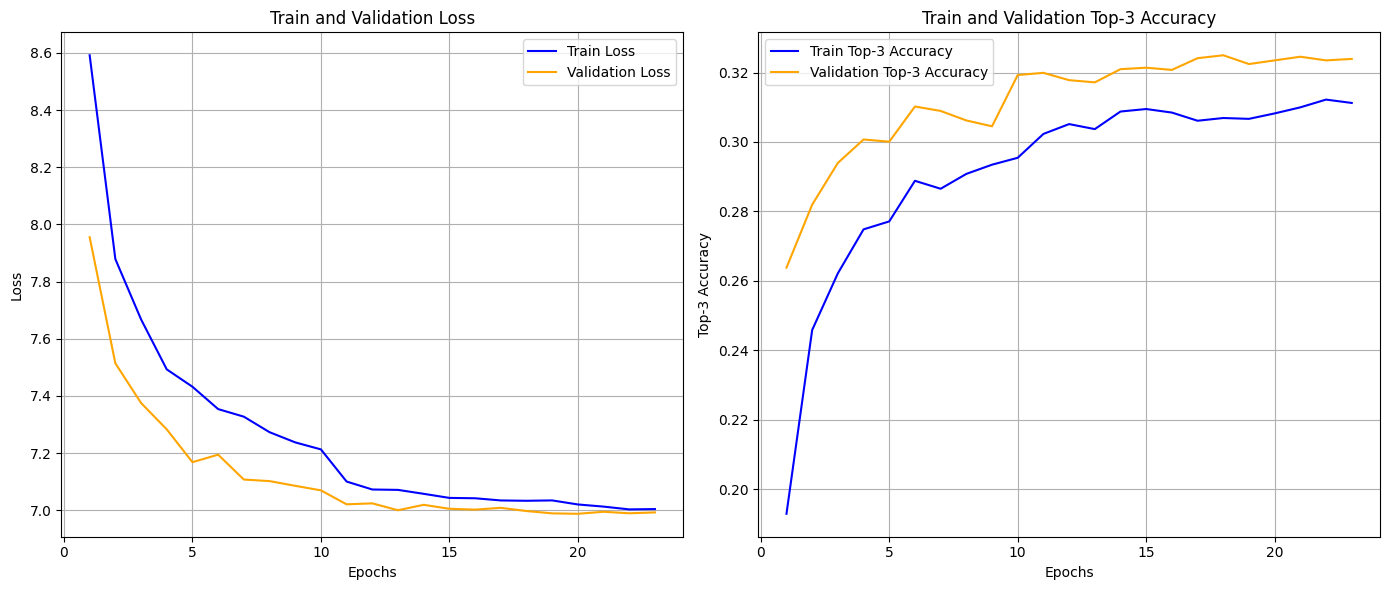

In [ ]:
epochs = range(1, len(train_losses) + 1)

# 그래프 생성
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, valid_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Top-3 Accuracy", color="blue")
plt.plot(epochs, valid_accs, label="Validation Top-3 Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Top-3 Accuracy")
plt.title("Train and Validation Top-3 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 데이터 증강 (Data Augmentation)


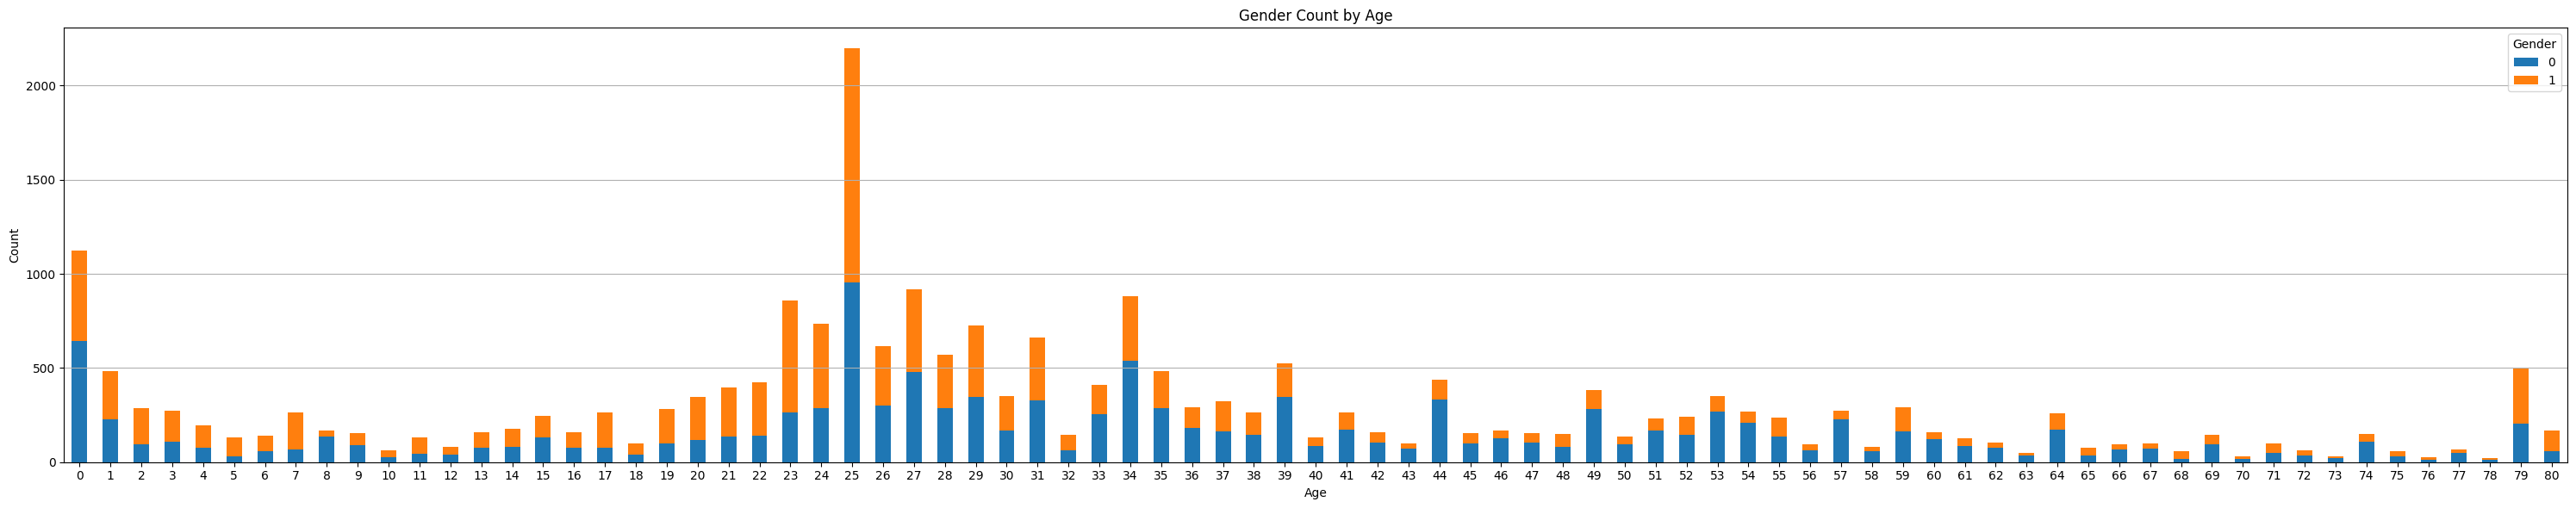

In [20]:
# Count the number of males and females by age
age_gender_counts = df.groupby(['age', 'gender']).size().unstack(fill_value=0)

# Plot the graph
age_gender_counts.plot(kind='bar', stacked=True, figsize=(30, 6))

# Set the title and labels
plt.title('Gender Count by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y')  # Add grid lines for better visualization

# Show the graph
plt.tight_layout()
plt.show()

## 1 . 언더 샘플링
26세(레이블 25) 데이터를 남성과 여성 각각 50% 비율로 균등하게 줄임

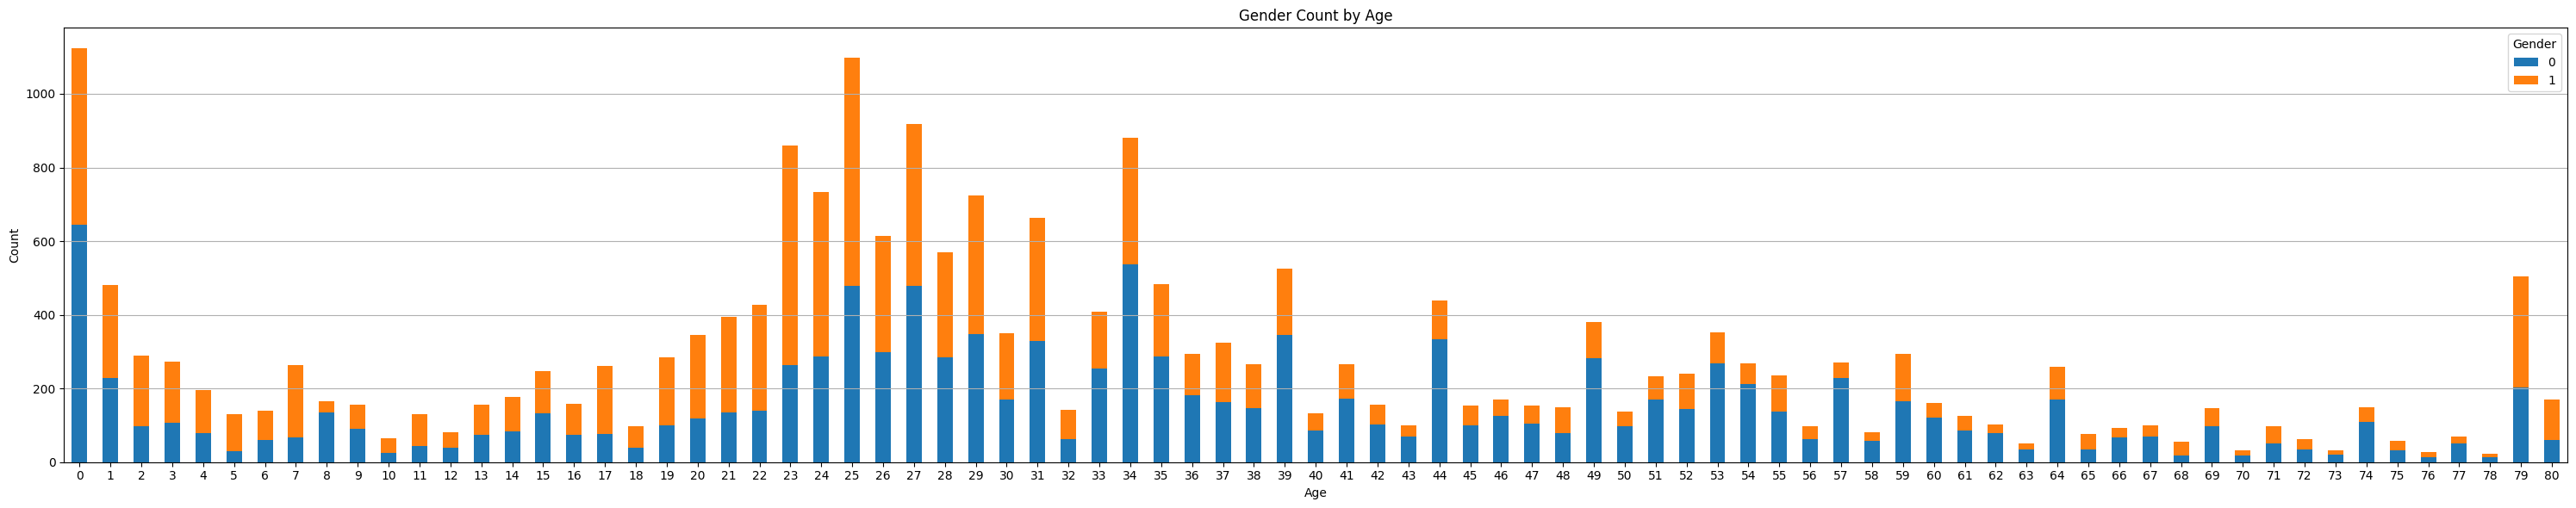

In [21]:
# age가 25인 데이터만 필터링
df_age_25 = df[df['age'] == 25]

# 성별로 나누기
df_male_25 = df_age_25[df_age_25['gender'] == 0]
df_female_25 = df_age_25[df_age_25['gender'] == 1]

# 각 성별에서 반으로 줄이기 (랜덤 샘플링)
df_male_25_reduced = df_male_25.sample(frac=0.5, random_state=42)  # 50% 샘플링
df_female_25_reduced = df_female_25.sample(frac=0.5, random_state=42)  # 50% 샘플링

# 남성, 여성 데이터를 합치기
df_reduced = pd.concat([df_male_25_reduced, df_female_25_reduced])

# 원본 df에서 age가 25인 데이터를 제외하고, 감소된 데이터를 합침
df = pd.concat([df[df['age'] != 25], df_reduced])

# Count the number of males and females by age
age_gender_counts = df.groupby(['age', 'gender']).size().unstack(fill_value=0)

# Plot the graph
age_gender_counts.plot(kind='bar', stacked=True, figsize=(30, 6))

# Set the title and labels
plt.title('Gender Count by Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.legend(title='Gender')
plt.grid(axis='y')  # Add grid lines for better visualization

# Show the graph
plt.tight_layout()
plt.show()

In [22]:
stratify_array = np.array(list(zip(df['age'], df['gender'])))

# df -> 70% train_df, 30% temp_df
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,  # 30% temp_df
    random_state=0,
    shuffle=True,
    stratify=stratify_array,
)

temp_stratify_array = np.array(list(zip(temp_df['age'], temp_df['gender'])))

# temp_df -> valid_df, test_df (2:1)
valid_df, test_df = train_test_split(
    temp_df,
    test_size=1/3,  # 1/3 test_df
    random_state=0,
    shuffle=True,
    stratify=temp_stratify_array,
)

# print result
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(valid_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 15827
Validation set size: 4522
Test set size: 2261


## 2 . 오버 샘플링

In [23]:
# Count the number of entries for each age (combining genders)
age_counts = train_df.groupby("age").size().reset_index(name="Count")

# Display the result
print(age_counts)

# Count 값을 기준으로 데이터를 나눌 구간(bins)과 레이블(labels) 정의
bins = [0, 120, 240, 480, float('inf')]  # 0~120, 121~240, 241~480, 481+ 구간 설정
labels = ['0-120', '121-240', '241-480', '481+']  # 각 구간에 대한 레이블 설정

# Count 값에 따라 Group 열 추가
age_counts['Group'] = pd.cut(age_counts['Count'], bins=bins, labels=labels)

# Group 열을 기준으로 age 값을 리스트 형태로 그룹화
age_groups = age_counts.groupby('Group', observed=False)['age'].apply(list)

# 결과를 사전 형태로 변환하여 보기 쉽게 정리
age_group_dict = age_groups.to_dict()

# 보기 좋은 형식으로 결과를 출력하는 함수 정의
def pretty_print_age_groups(age_group_dict):
    for group, ages in age_group_dict.items():
        print(f"{group}:")
        print(", ".join(map(str, ages)))
        print()  # 각 그룹 사이에 빈 줄 추가

# 결과를 보기 좋게 출력
pretty_print_age_groups(age_group_dict)

    age  Count
0     0    786
1     1    338
2     2    202
3     3    192
4     4    138
..  ...    ...
76   76     20
77   77     49
78   78     16
79   79    353
80   80    118

[81 rows x 2 columns]
0-120:
5, 6, 8, 9, 10, 11, 12, 13, 16, 18, 32, 40, 42, 43, 45, 46, 47, 48, 50, 56, 58, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 80

121-240:
2, 3, 4, 7, 14, 15, 17, 19, 36, 37, 38, 41, 51, 52, 54, 55, 57, 59, 64

241-480:
1, 20, 21, 22, 26, 28, 30, 31, 33, 35, 39, 44, 49, 53, 79

481+:
0, 23, 24, 25, 27, 29, 34



In [24]:
# 특정 레이블을 가진 데이터만 포함하는 AugmentedDataset 클래스 생성
class AugmentedDataset(Dataset):
    def __init__(self, base_dataset, include_ages, transform=None):
        """
        :param base_dataset: 기존 Dataset 객체
        :param include_ages: 포함할 나이 리스트
        :param transform: 이미지에 적용할 전처리(transform) 함수
        """
        # base_dataset에서 나이 필터링
        self.filtered_dataset = [
            base_dataset[i] for i in range(len(base_dataset)) if base_dataset[i][1] in include_ages
        ]
        self.transform = transform

    def __len__(self):
        """데이터셋의 총 샘플 수 반환"""
        return len(self.filtered_dataset)

    def __getitem__(self, idx):
        """
        주어진 인덱스(idx)에 해당하는 샘플 반환
        """
        img, age, gender = self.filtered_dataset[idx]

        # 텐서를 PIL 이미지로 변환 (이미지가 텐서일 경우)
        if isinstance(img, torch.Tensor):
            img = transforms.ToPILImage()(img)

        # transform 적용
        if self.transform:
            img = self.transform(img)

        return img, age, gender


# 데이터 증강을 위한 transform 정의
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=2, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),  # 이미지를 텐서로 변환
    transforms.Lambda(lambda x: x / 255.0)  # 255로 나누어 [0, 1] 범위로 변환
])


In [25]:
ages_0 = age_group_dict['0-120']
ages_120 = age_group_dict['121-240']
ages_240 = age_group_dict['241-480']

# 데이터셋 로딩
train_dataset = CustomDataset(dataframe=train_df, transform=transform)
valid_dataset = CustomDataset(dataframe=valid_df, transform=transform)
test_dataset = CustomDataset(dataframe=test_df, transform=transform)

# 증강 1
augmented_train_dataset1 = AugmentedDataset(train_dataset, ages_0, transform=augment_transform)
# 증강된 데이터셋을 결합
combined_train_dataset1 = ConcatDataset([train_dataset, augmented_train_dataset1])

# 증강 2
augmented_train_dataset2 = AugmentedDataset(combined_train_dataset1, ages_0 + ages_120, transform=augment_transform)
# 증강된 데이터셋을 결합
combined_train_dataset2 = ConcatDataset([combined_train_dataset1, augmented_train_dataset2])

# 증강 3
augmented_train_dataset3 = AugmentedDataset(combined_train_dataset2, ages_0 + ages_120 + ages_240, transform=augment_transform)
# 증강된 데이터셋을 결합
combined_train_dataset3 = ConcatDataset([combined_train_dataset2, augmented_train_dataset3])

# 데이터 로더 설정
train_loader = DataLoader(combined_train_dataset3, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

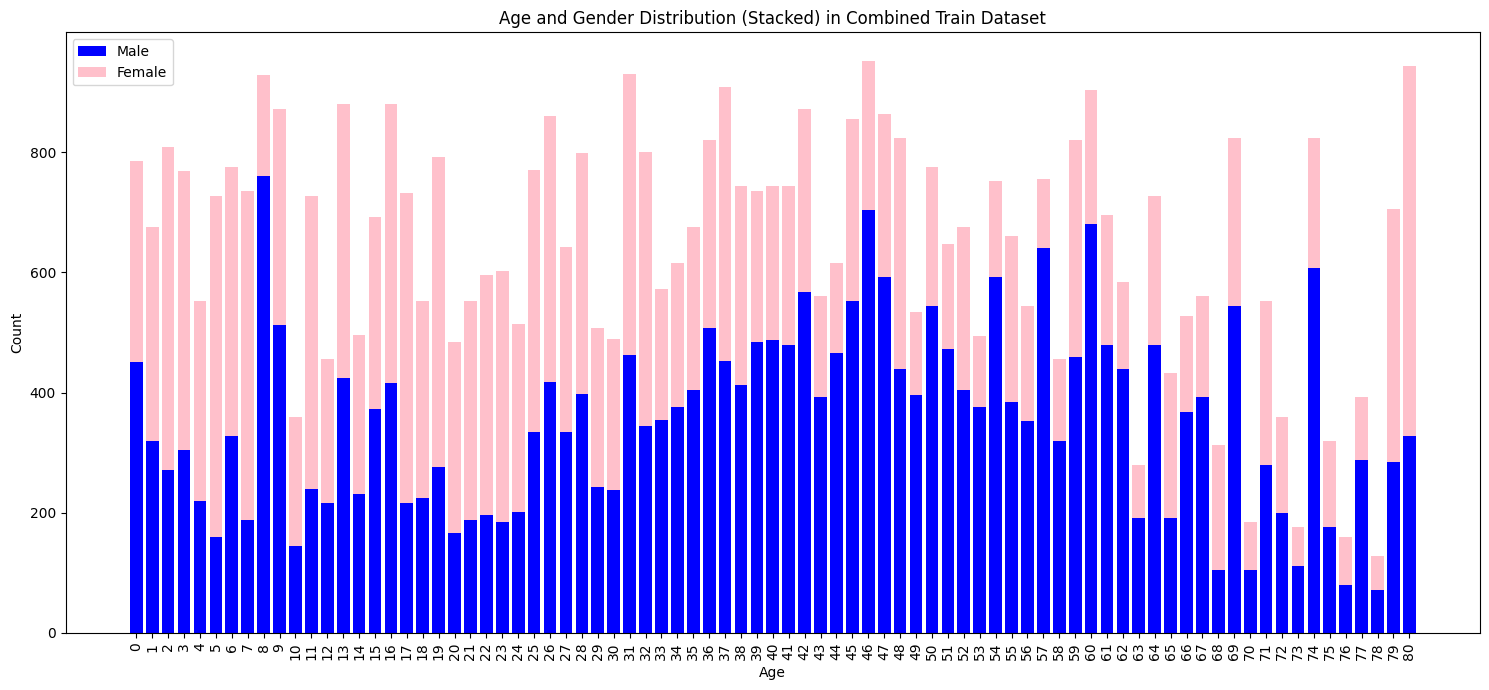

In [26]:
def plot_age_gender_stacked(dataset, title):
    """
    주어진 데이터셋에서 나이에 따른 성별 분포를 스택형 막대 그래프로 시각화합니다.

    Args:
    - dataset: PyTorch Dataset 또는 ConcatDataset
    - title: 그래프 제목
    """
    # 모든 샘플에서 (age, gender) 데이터를 추출
    age_gender = []
    for _, age, gender in dataset:
        age_gender.append((age, gender))

    # 나이별로 남성과 여성의 수를 집계
    age_gender_counter = Counter(age_gender)
    age_labels = sorted(set(age for age, _ in age_gender))
    male_counts = [age_gender_counter[(age, 0)] for age in age_labels]  # 성별 0 (남성)
    female_counts = [age_gender_counter[(age, 1)] for age in age_labels]  # 성별 1 (여성)

    # 그래프 생성
    x = np.arange(len(age_labels))

    plt.figure(figsize=(15, 7))
    plt.bar(x, male_counts, label='Male', color='blue')  # 남성
    plt.bar(x, female_counts, bottom=male_counts, label='Female', color='pink')  # 여성 (남성 위에 쌓음)

    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.title(title)
    plt.xticks(x, age_labels, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 학습 데이터셋 분포 (스택형 그래프)
plot_age_gender_stacked(combined_train_dataset3, "Age and Gender Distribution (Stacked) in Combined Train Dataset")

In [ ]:
num_epochs = 50
best_val_acc = 0.0
patience = 5
no_improve = 0

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_gender_train = 0
    correct_age_train_top3 = 0
    total_train = 0

    for inputs, ages, genders in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", dynamic_ncols=True):
        inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        gender_logits = model.gender_output(outputs)
        age_logits = model.age_output(outputs)

        loss_gender = criterion_gender(gender_logits, genders)
        loss_age = criterion_age(age_logits, ages)
        loss = loss_gender + loss_age

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted_gender = torch.max(gender_logits, 1)
        correct_gender_train += (predicted_gender == genders).sum().item()

        _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
        correct_age_train_top3 += sum([ages[i] in predicted_age_top3[i] for i in range(len(ages))])
        total_train += ages.size(0)

    avg_loss = running_loss / len(train_loader)
    train_acc_gender = correct_gender_train / total_train
    train_acc_age_top3 = correct_age_train_top3 / total_train

    model.eval()
    correct_gender_val = 0
    correct_age_val_top3 = 0
    total_val = 0
    running_val_loss = 0.0

    with torch.no_grad():
        for inputs, ages, genders in valid_loader:
            inputs, ages, genders = inputs.to(device), ages.to(device), genders.to(device)

            outputs = model(inputs)
            gender_logits = model.gender_output(outputs)
            age_logits = model.age_output(outputs)

            loss_gender = criterion_gender(gender_logits, genders)
            loss_age = criterion_age(age_logits, ages)
            val_loss = loss_gender + loss_age
            running_val_loss += val_loss.item()

            _, predicted_gender = torch.max(gender_logits, 1)
            correct_gender_val += (predicted_gender == genders).sum().item()

            _, predicted_age_top3 = torch.topk(age_logits, k=3, dim=1)
            correct_age_val_top3 += sum([ages[i] in predicted_age_top3[i] for i in range(len(ages))])
            total_val += ages.size(0)

    avg_val_loss = running_val_loss / len(valid_loader)
    val_acc_gender = correct_gender_val / total_val
    val_acc_age_top3 = correct_age_val_top3 / total_val

    train_losses.append(avg_loss)
    valid_losses.append(avg_val_loss)

    train_accs.append(train_acc_age_top3)
    valid_accs.append(val_acc_age_top3)

    print(f"Epoch [{epoch+1}/{num_epochs}]:")
    print(f"  Train Loss: {avg_loss:.4f}, Train Gender Acc: {train_acc_gender:.4f}, Train Age Top-3 Acc: {train_acc_age_top3:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Gender Acc: {val_acc_gender:.4f}, Val Age Top-3 Acc: {val_acc_age_top3:.4f}")

    if val_acc_age_top3 > best_val_acc:
        best_val_acc = val_acc_age_top3
        torch.save(model.state_dict(), 'best_model.pth') # add
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break


Epoch 1/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [1/50]:
  Train Loss: 3.7655, Train Gender Acc: 0.9330, Train Age Top-3 Acc: 0.2607
  Val Loss: 3.4497, Val Gender Acc: 0.9253, Val Age Top-3 Acc: 0.3254


Epoch 2/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [2/50]:
  Train Loss: 3.5816, Train Gender Acc: 0.9468, Train Age Top-3 Acc: 0.2975
  Val Loss: 3.3478, Val Gender Acc: 0.9386, Val Age Top-3 Acc: 0.3408


Epoch 3/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [3/50]:
  Train Loss: 3.4762, Train Gender Acc: 0.9538, Train Age Top-3 Acc: 0.3190
  Val Loss: 3.2992, Val Gender Acc: 0.9378, Val Age Top-3 Acc: 0.3456


Epoch 4/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [4/50]:
  Train Loss: 3.3812, Train Gender Acc: 0.9593, Train Age Top-3 Acc: 0.3386
  Val Loss: 3.2318, Val Gender Acc: 0.9431, Val Age Top-3 Acc: 0.3667


Epoch 5/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [5/50]:
  Train Loss: 3.2898, Train Gender Acc: 0.9615, Train Age Top-3 Acc: 0.3615
  Val Loss: 3.1904, Val Gender Acc: 0.9458, Val Age Top-3 Acc: 0.3749


Epoch 6/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [6/50]:
  Train Loss: 3.2086, Train Gender Acc: 0.9658, Train Age Top-3 Acc: 0.3806
  Val Loss: 3.1426, Val Gender Acc: 0.9479, Val Age Top-3 Acc: 0.3870


Epoch 7/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [7/50]:
  Train Loss: 3.1231, Train Gender Acc: 0.9678, Train Age Top-3 Acc: 0.4016
  Val Loss: 3.1149, Val Gender Acc: 0.9509, Val Age Top-3 Acc: 0.4043


Epoch 8/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [8/50]:
  Train Loss: 3.0467, Train Gender Acc: 0.9692, Train Age Top-3 Acc: 0.4234
  Val Loss: 3.0807, Val Gender Acc: 0.9488, Val Age Top-3 Acc: 0.4167


Epoch 9/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [9/50]:
  Train Loss: 2.9686, Train Gender Acc: 0.9700, Train Age Top-3 Acc: 0.4452
  Val Loss: 3.0182, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.4315


Epoch 10/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [10/50]:
  Train Loss: 2.8895, Train Gender Acc: 0.9723, Train Age Top-3 Acc: 0.4634
  Val Loss: 3.0176, Val Gender Acc: 0.9509, Val Age Top-3 Acc: 0.4460


Epoch 11/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [11/50]:
  Train Loss: 2.8166, Train Gender Acc: 0.9737, Train Age Top-3 Acc: 0.4849
  Val Loss: 2.9568, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.4642


Epoch 12/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [12/50]:
  Train Loss: 2.7252, Train Gender Acc: 0.9752, Train Age Top-3 Acc: 0.5118
  Val Loss: 2.9316, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.4749


Epoch 13/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [13/50]:
  Train Loss: 2.6490, Train Gender Acc: 0.9745, Train Age Top-3 Acc: 0.5340
  Val Loss: 2.8951, Val Gender Acc: 0.9530, Val Age Top-3 Acc: 0.4905


Epoch 14/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [14/50]:
  Train Loss: 2.5719, Train Gender Acc: 0.9759, Train Age Top-3 Acc: 0.5522
  Val Loss: 2.8840, Val Gender Acc: 0.9534, Val Age Top-3 Acc: 0.5063


Epoch 15/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [15/50]:
  Train Loss: 2.4883, Train Gender Acc: 0.9761, Train Age Top-3 Acc: 0.5767
  Val Loss: 2.8150, Val Gender Acc: 0.9542, Val Age Top-3 Acc: 0.5186


Epoch 16/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [16/50]:
  Train Loss: 2.4152, Train Gender Acc: 0.9760, Train Age Top-3 Acc: 0.5945
  Val Loss: 2.7704, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.5375


Epoch 17/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [17/50]:
  Train Loss: 2.3370, Train Gender Acc: 0.9762, Train Age Top-3 Acc: 0.6148
  Val Loss: 2.7682, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.5458


Epoch 18/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [18/50]:
  Train Loss: 2.2656, Train Gender Acc: 0.9773, Train Age Top-3 Acc: 0.6343
  Val Loss: 2.7104, Val Gender Acc: 0.9532, Val Age Top-3 Acc: 0.5586


Epoch 19/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [19/50]:
  Train Loss: 2.1833, Train Gender Acc: 0.9772, Train Age Top-3 Acc: 0.6561
  Val Loss: 2.6791, Val Gender Acc: 0.9528, Val Age Top-3 Acc: 0.5685


Epoch 20/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [20/50]:
  Train Loss: 2.1147, Train Gender Acc: 0.9765, Train Age Top-3 Acc: 0.6732
  Val Loss: 2.6545, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.5818


Epoch 21/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [21/50]:
  Train Loss: 2.0358, Train Gender Acc: 0.9768, Train Age Top-3 Acc: 0.6910
  Val Loss: 2.6118, Val Gender Acc: 0.9532, Val Age Top-3 Acc: 0.5960


Epoch 22/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [22/50]:
  Train Loss: 1.9657, Train Gender Acc: 0.9780, Train Age Top-3 Acc: 0.7054
  Val Loss: 2.5993, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.5993


Epoch 23/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [23/50]:
  Train Loss: 1.8981, Train Gender Acc: 0.9779, Train Age Top-3 Acc: 0.7188
  Val Loss: 2.5896, Val Gender Acc: 0.9528, Val Age Top-3 Acc: 0.6038


Epoch 24/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [24/50]:
  Train Loss: 1.8262, Train Gender Acc: 0.9795, Train Age Top-3 Acc: 0.7414
  Val Loss: 2.5177, Val Gender Acc: 0.9523, Val Age Top-3 Acc: 0.6151


Epoch 25/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [25/50]:
  Train Loss: 1.7638, Train Gender Acc: 0.9778, Train Age Top-3 Acc: 0.7500
  Val Loss: 2.5041, Val Gender Acc: 0.9534, Val Age Top-3 Acc: 0.6274


Epoch 26/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [26/50]:
  Train Loss: 1.6945, Train Gender Acc: 0.9787, Train Age Top-3 Acc: 0.7637
  Val Loss: 2.5022, Val Gender Acc: 0.9511, Val Age Top-3 Acc: 0.6293


Epoch 27/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [27/50]:
  Train Loss: 1.6301, Train Gender Acc: 0.9785, Train Age Top-3 Acc: 0.7778
  Val Loss: 2.4595, Val Gender Acc: 0.9517, Val Age Top-3 Acc: 0.6329


Epoch 28/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [28/50]:
  Train Loss: 1.5762, Train Gender Acc: 0.9785, Train Age Top-3 Acc: 0.7891
  Val Loss: 2.4542, Val Gender Acc: 0.9517, Val Age Top-3 Acc: 0.6394


Epoch 29/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [29/50]:
  Train Loss: 1.5128, Train Gender Acc: 0.9790, Train Age Top-3 Acc: 0.8015
  Val Loss: 2.4570, Val Gender Acc: 0.9500, Val Age Top-3 Acc: 0.6385


Epoch 30/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [30/50]:
  Train Loss: 1.4550, Train Gender Acc: 0.9795, Train Age Top-3 Acc: 0.8154
  Val Loss: 2.4087, Val Gender Acc: 0.9507, Val Age Top-3 Acc: 0.6445


Epoch 31/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [31/50]:
  Train Loss: 1.3979, Train Gender Acc: 0.9794, Train Age Top-3 Acc: 0.8251
  Val Loss: 2.3996, Val Gender Acc: 0.9513, Val Age Top-3 Acc: 0.6495


Epoch 32/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [32/50]:
  Train Loss: 1.3489, Train Gender Acc: 0.9793, Train Age Top-3 Acc: 0.8341
  Val Loss: 2.3559, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.6554


Epoch 33/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [33/50]:
  Train Loss: 1.2941, Train Gender Acc: 0.9799, Train Age Top-3 Acc: 0.8445
  Val Loss: 2.3471, Val Gender Acc: 0.9536, Val Age Top-3 Acc: 0.6565


Epoch 34/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [34/50]:
  Train Loss: 1.2439, Train Gender Acc: 0.9806, Train Age Top-3 Acc: 0.8510
  Val Loss: 2.3461, Val Gender Acc: 0.9511, Val Age Top-3 Acc: 0.6603


Epoch 35/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [35/50]:
  Train Loss: 1.1988, Train Gender Acc: 0.9809, Train Age Top-3 Acc: 0.8622
  Val Loss: 2.3198, Val Gender Acc: 0.9528, Val Age Top-3 Acc: 0.6590


Epoch 36/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [36/50]:
  Train Loss: 1.1461, Train Gender Acc: 0.9800, Train Age Top-3 Acc: 0.8695
  Val Loss: 2.3478, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.6620


Epoch 37/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [37/50]:
  Train Loss: 1.1073, Train Gender Acc: 0.9806, Train Age Top-3 Acc: 0.8755
  Val Loss: 2.3480, Val Gender Acc: 0.9509, Val Age Top-3 Acc: 0.6611


Epoch 38/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [38/50]:
  Train Loss: 1.0616, Train Gender Acc: 0.9808, Train Age Top-3 Acc: 0.8845
  Val Loss: 2.3189, Val Gender Acc: 0.9513, Val Age Top-3 Acc: 0.6666


Epoch 39/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [39/50]:
  Train Loss: 1.0281, Train Gender Acc: 0.9813, Train Age Top-3 Acc: 0.8896
  Val Loss: 2.3255, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.6645


Epoch 40/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [40/50]:
  Train Loss: 0.9822, Train Gender Acc: 0.9821, Train Age Top-3 Acc: 0.8953
  Val Loss: 2.2948, Val Gender Acc: 0.9534, Val Age Top-3 Acc: 0.6704


Epoch 41/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [41/50]:
  Train Loss: 0.9468, Train Gender Acc: 0.9819, Train Age Top-3 Acc: 0.9006
  Val Loss: 2.3247, Val Gender Acc: 0.9534, Val Age Top-3 Acc: 0.6645


Epoch 42/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [42/50]:
  Train Loss: 0.9133, Train Gender Acc: 0.9819, Train Age Top-3 Acc: 0.9061
  Val Loss: 2.3068, Val Gender Acc: 0.9500, Val Age Top-3 Acc: 0.6702


Epoch 43/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [43/50]:
  Train Loss: 0.8785, Train Gender Acc: 0.9828, Train Age Top-3 Acc: 0.9106
  Val Loss: 2.3239, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.6721


Epoch 44/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [44/50]:
  Train Loss: 0.8519, Train Gender Acc: 0.9832, Train Age Top-3 Acc: 0.9158
  Val Loss: 2.3732, Val Gender Acc: 0.9540, Val Age Top-3 Acc: 0.6681


Epoch 45/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [45/50]:
  Train Loss: 0.8155, Train Gender Acc: 0.9833, Train Age Top-3 Acc: 0.9193
  Val Loss: 2.3394, Val Gender Acc: 0.9492, Val Age Top-3 Acc: 0.6706


Epoch 46/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [46/50]:
  Train Loss: 0.7815, Train Gender Acc: 0.9839, Train Age Top-3 Acc: 0.9252
  Val Loss: 2.3773, Val Gender Acc: 0.9519, Val Age Top-3 Acc: 0.6710


Epoch 47/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [47/50]:
  Train Loss: 0.7605, Train Gender Acc: 0.9836, Train Age Top-3 Acc: 0.9278
  Val Loss: 2.4027, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.6687


Epoch 48/50: 100%|██████████| 427/427 [02:44<00:00,  2.59it/s]


Epoch [48/50]:
  Train Loss: 0.7273, Train Gender Acc: 0.9846, Train Age Top-3 Acc: 0.9325
  Val Loss: 2.3927, Val Gender Acc: 0.9526, Val Age Top-3 Acc: 0.6731


Epoch 49/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [49/50]:
  Train Loss: 0.7168, Train Gender Acc: 0.9838, Train Age Top-3 Acc: 0.9344
  Val Loss: 2.4271, Val Gender Acc: 0.9504, Val Age Top-3 Acc: 0.6700


Epoch 50/50: 100%|██████████| 427/427 [02:44<00:00,  2.60it/s]


Epoch [50/50]:
  Train Loss: 0.6825, Train Gender Acc: 0.9848, Train Age Top-3 Acc: 0.9379
  Val Loss: 2.3924, Val Gender Acc: 0.9523, Val Age Top-3 Acc: 0.6763


## Loss, Top-3 Accuracy 시각화

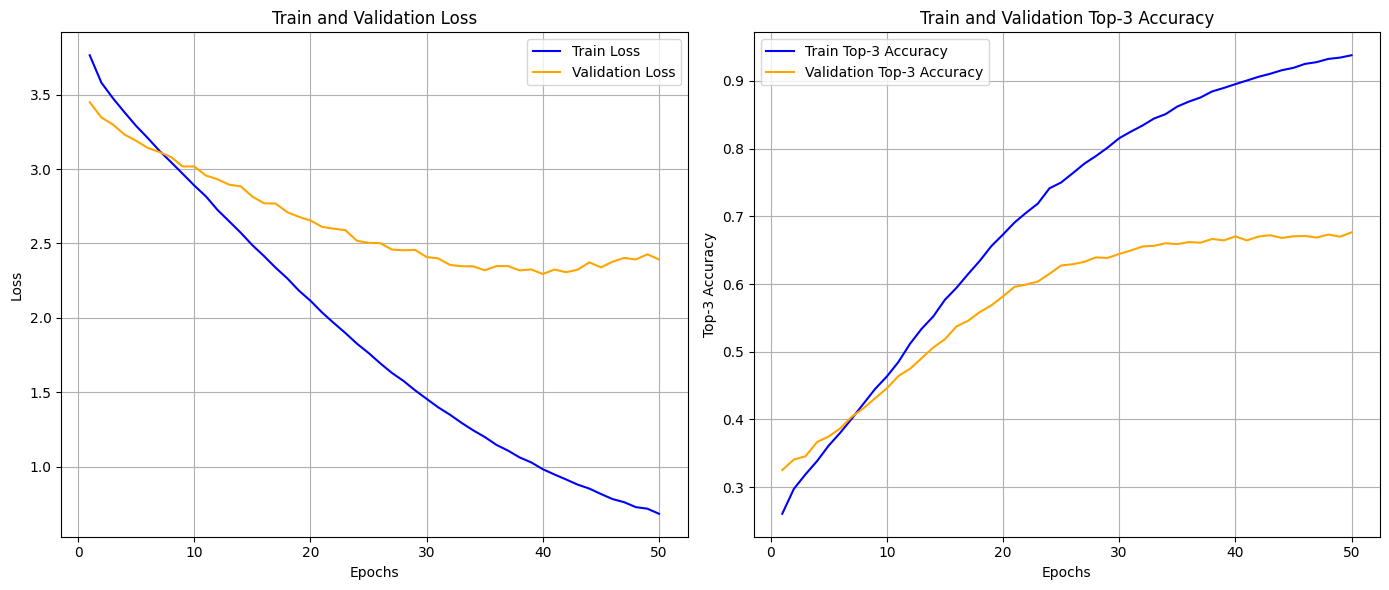

In [ ]:
epochs = range(1, len(train_losses) + 1)

# 그래프 생성
plt.figure(figsize=(14, 6))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color="blue")
plt.plot(epochs, valid_losses, label="Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.grid(True)

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label="Train Top-3 Accuracy", color="blue")
plt.plot(epochs, valid_accs, label="Validation Top-3 Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Top-3 Accuracy")
plt.title("Train and Validation Top-3 Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Best Model

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
model = model.to('cuda')

<ipython-input-32-5c292473c2ee>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_before (1).pth'))
